**Self implemantation of DALL-E Model:**

In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.nn import Transformer
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os

In [2]:
# --- Lightweight Residual Block ---
class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(channels)
        self.norm2 = nn.BatchNorm2d(channels)
    
    def forward(self, x):
        residual = x
        x = self.norm1(F.relu(self.conv1(x)))
        x = self.norm2(F.relu(self.conv2(x)))
        return x + residual

In [3]:
class SharedImageEmbedding(nn.Module):
    def __init__(self, num_embeddings=4096, embedding_dim=256):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding_dim = embedding_dim

    def forward(self, token_ids):
        B, H, W = token_ids.shape  # (B, 32, 32)

        # Flatten indices for embedding lookup (B, 32, 32) → (B, 1024)
        token_ids_flat = token_ids.view(B, -1)

        # Get embeddings from lookup table (B, 1024, embedding_dim)
        token_embeddings = self.embedding(token_ids_flat)

        # Reshape back to spatial format (B, embedding_dim, 32, 32)
        token_embeddings = token_embeddings.view(B, self.embedding_dim, H, W)

        return token_embeddings  # Shape: (B, embedding_dim, 32, 32)

In [4]:
class GumbelSoftmaxVectorQuantizer(nn.Module):
    def __init__(self, embedding, tau_init=1.0, tau_min=1/16, anneal_rate=0.99995, num_embeddings=8192):
        """
        Gumbel-Softmax Vector Quantizer for discretizing latent representations.

        Args:
            tau_init (float): Initial temperature for Gumbel-Softmax (default: 1.0).
            tau_min (float): Minimum temperature value (default: 1/16).
            anneal_rate (float): Annealing rate for temperature decay (default: 0.99995).
            num_embeddings (int): Number of discrete image tokens (default: 8192).
        """
        super().__init__()
        self.tau = tau_init
        self.tau_min = tau_min
        self.anneal_rate = anneal_rate
        self.num_embeddings = num_embeddings

        # Embedding lookup table for quantization
        self.embedding = embedding

    def sample_gumbel(self, shape, eps=1e-10):
        """ Sample from Gumbel(0,1) distribution """
        U = torch.rand(shape, device="cuda" if torch.cuda.is_available() else "cpu")
        return -torch.log(-torch.log(U + eps) + eps)

    def gumbel_softmax(self, logits):
        """ Apply Gumbel-Softmax trick """
        gumbel_noise = self.sample_gumbel(logits.shape)
        y = logits + gumbel_noise
        return F.softmax(y / self.tau, dim=-1)

    def forward(self, x):
        """
        Forward pass of Gumbel-Softmax Vector Quantization.

        Args:
            x (torch.Tensor): Latent features from encoder (B, 64, 32, 32).

        Returns:
            indices (torch.Tensor): Discrete token indices of shape (B, 32, 32).
        """
        B, C, H, W = x.shape  # (Batch, Channels, Height, Width)

        # Reshape for quantization (B, 64, 32, 32) → (B, 32, 32, 64) → (B, H*W, 64)
        x_flat = x.permute(0, 2, 3, 1).reshape(B, H * W, C)

        # Compute logits for vector quantization (B, H*W, K)
        logits = F.linear(x_flat, self.embedding.embedding.weight)  # (B, H*W, num_embeddings)

        # Apply Gumbel-Softmax trick
        soft_one_hot = self.gumbel_softmax(logits)  # (B, H*W, num_embeddings)

        # Convert soft representation into hard discrete indices
        indices = torch.argmax(soft_one_hot, dim=-1)  # (B, H*W)

        # Reshape back to spatial format (B, H, W)
        indices = indices.view(B, H, W)

        # Anneal temperature
        self.tau = max(self.tau * self.anneal_rate, self.tau_min)

        return indices, soft_one_hot, logits  # (B, 32, 32) → Image tokens

In [5]:
# --- dVAE Encoder ---
class dVAE_Encoder(nn.Module):
    def __init__(self, in_channels=3, hidden_dim=128):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=7, stride=2, padding=3)  # Downsample 256 → 128
        self.resblocks = nn.Sequential(
            ResBlock(32), 
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 128 → 64
            ResBlock(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),  # 64 → 32
            ResBlock(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 32 → 16
            ResBlock(128),
            nn.Conv2d(128, hidden_dim, kernel_size=3, stride=2, padding=1),  # 16 → 8
        )

    def forward(self, x):
        return self.resblocks(self.conv1(x))

# --- dVAE Decoder ---
class dVAE_Decoder(nn.Module):
    def __init__(self, hidden_dim=128, out_channels=6):
        super().__init__()

        self.deconv1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1)  # 1x1 before upsampling

        self.resblocks = nn.Sequential(
            ResBlock(hidden_dim),
            nn.ConvTranspose2d(hidden_dim, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8 → 16
            ResBlock(128),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16 → 32
            ResBlock(64),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32 → 64
            ResBlock(32),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64 → 128
            ResBlock(16),
            nn.ConvTranspose2d(16, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),  # 128 → 256
        )

    def forward(self, x):
        x = self.deconv1(x)
        x = self.resblocks(x)
        mu, log_b = torch.split(x, 3, dim=1)  # Split output into µ (mean) and ln b (log scale)
        return mu, log_b


# --- Full dVAE Model ---
class dVAE(nn.Module):
    def __init__(self, num_embeddings=528, embedding_dim=128):
        super().__init__()
        self.encoder = dVAE_Encoder(hidden_dim=embedding_dim)
        self.shared_image_embedding = SharedImageEmbedding(num_embeddings, embedding_dim)
        self.vq = GumbelSoftmaxVectorQuantizer(self.shared_image_embedding)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.decoder = dVAE_Decoder(hidden_dim=embedding_dim)

    def forward(self, x):
        encoded = self.encoder(x)  # Encode image
        indices, token_probs, logits_gumbel = self.vq(encoded, self.shared_image_embedding)  # Quantize using Gumbel-Softmax
        token_embeddings = self.shared_image_embedding(indices)  # Convert tokens to embeddings
        decoded = self.decoder(token_embeddings)  # Decode back to image
        return decoded, indices  # Return the discrete tokens

In [6]:
class Transformer(nn.Module):
    def __init__(self, vocab_size=50257, image_vocab_size=4096, embed_dim=256, num_layers=6, num_heads=8, shared_image_embedding=None):
        """
        Decoder-Only Transformer (GPT-style) for DALL·E.

        Args:
            vocab_size (int): Vocabulary size for text tokens (default: 50257).
            image_vocab_size (int): Number of discrete image tokens (default: 4096).
            embed_dim (int): Embedding dimension (default: 256).
            num_layers (int): Number of transformer decoder layers (default: 6).
            num_heads (int): Number of attention heads (default: 8).
            shared_image_embedding (nn.Embedding): Shared embedding for image tokens.
        """
        super().__init__()
        
        # Text and Image Token Embeddings
        self.text_embedding = nn.Embedding(vocab_size, embed_dim)  # Text token embeddings
        self.image_embedding = shared_image_embedding  # Shared image embedding

        # Positional Encoding
        self.positional_encoding = nn.Embedding(1024, embed_dim)  # Maximum sequence length

        # Transformer Decoder
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=4 * embed_dim,
            batch_first=True  # Ensures (batch, seq, dim) format
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # Output Projection (Predict next token logits)
        self.lm_head = nn.Linear(embed_dim, vocab_size + image_vocab_size)  # Predict text or image token

    def forward(self, text_tokens, image_tokens):
        """
        Forward pass of Transformer.

        Args:
            text_tokens (torch.Tensor): Text token indices (batch, seq_len).
            image_tokens (torch.Tensor): Image token indices (batch, image_seq_len).

        Returns:
            torch.Tensor: Output of transformer.
        """
        # Convert tokens to embeddings
        text_embeds = self.text_embedding(text_tokens)  # Text token embeddings
        image_embeds = self.image_embedding(image_tokens)  # Image token embeddings (shared with dVAE)

        # Concatenate text and image embeddings
        input_embeds = torch.cat([text_embeds, image_embeds], dim=1)

        # Pass through Transformer
        output = self.transformer(input_embeds, input_embeds)
        return output


**Data - NoCaps Dataset**

In [2]:
import torch
import torchvision.transforms as transforms
from tokenizers import Tokenizer
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle
from torch.amp import autocast, GradScaler
import math
import torch.nn.functional as F
import torchvision.transforms as T
from dalle_pytorch import DiscreteVAE, DALLE

In [8]:
# Load the NoCaps dataset
dataset = load_dataset('lmms-lab/NoCaps')

# Access specific splits correctly
dataset_val = dataset['validation']
dataset_test = dataset['test']

In [9]:
# Define epsilon for ϕ transformation
EPSILON = 0.1

# Apply the ϕ transformation on raw pixel values (as in DALL-E paper)
def transform_pixels(x):
    return ((1 - 2 * EPSILON) / 255.0) * x + EPSILON  # Applied to raw [0,255] values

# Preprocessing function
def preprocess_image(image):
    # Step 1: Resize image to 256x256
    image = image.resize((256, 256), Image.BICUBIC)

    # Step 2: Convert to NumPy array (range [0, 255])
    image_np = np.array(image, dtype=np.float32).reshape(256, 256, 3)
    # Step 3: Apply the ϕ transformation
    transformed_image = transform_pixels(image_np)

    # Step 4: Convert to PyTorch Tensor and change shape (H, W, C) → (C, H, W)
    transformed_image = torch.tensor(transformed_image).permute(2, 0, 1)  # (3, 256, 256)
    
    return transformed_image

def create_pairs(dataset):
    image_caption_pairs_train, image_caption_pairs_test = [], []
    test_idx = math.ceil(0.95 * len(dataset))
    for idx in range(len(dataset)):  # Use index-based access instead of iteration
        try:
            item = dataset[idx]  # Load item lazily
            image = item['image']
            captions = item.get('annotations_captions', [])

            if captions == []:
                continue

            if image.mode != "RGB":
                continue
            
            # Preprocess and filter out non-RGB or corrupted images
            processed_image = preprocess_image(image)
            if processed_image is None:
                continue  # Skip this sample
            
            # Store each caption as a separate training example
            for caption in captions:
                if idx < test_idx:
                    image_caption_pairs_train.append((processed_image, caption))
                else:
                    image_caption_pairs_test.append((processed_image, caption))
        
        except Exception as e:
            print(f"Skipping item {idx} due to error: {e}")
            continue  # Skip problematic dataset entries
    
    return image_caption_pairs_train, image_caption_pairs_test

In [10]:
train_data, test_data = create_pairs(dataset_val)

# Check dataset sizes
print(f"Train Samples: {len(train_data)}")
print(f"Test Samples: {len(test_data)}")

Train Samples: 42140
Test Samples: 2230


In [11]:
# File paths for saving
train_data_path = "train_data.pkl"
test_data_path = "test_data.pkl"

# Save datasets
with open(train_data_path, "wb") as f:
    pickle.dump(train_data, f)

with open(test_data_path, "wb") as f:
    pickle.dump(test_data, f)

In [3]:
# Function to load prepared datasets
def load_datasets():
    with open(train_data_path, "rb") as f:
        train_data = pickle.load(f)

    with open(test_data_path, "rb") as f:
        test_data = pickle.load(f)
    
    return train_data, test_data

train_data_path = "train_data.pkl"
test_data_path = "test_data.pkl"
# Test loading
train_data, test_data = load_datasets()

# Verify dataset sizes
print(f"Loaded Train Samples: {len(train_data)}")
print(f"Loaded Test Samples: {len(test_data)}")

Loaded Train Samples: 42140
Loaded Test Samples: 2230


['A baby is standing in front of a house.', 'A little girl in a white jacket and sandals.', 'A young child stands in front of a house.', 'A child is wearing a white shirt and standing on a side walk. ', 'A little boy is standing in his diaper with a white shirt on.', 'A child wearing a diaper and shoes stands on the sidewalk.', 'A child is wearing a light-colored shirt during the daytime.', 'A little kid standing on the pavement in a shirt. ', 'Black and white photo of a little girl smiling.', 'a cute baby is standing alone with white shirt']
["An elephant standing in front of a tree, wearing a saddle on it's back.", 'An elephant mounted with a chair and another beside it afar ', 'An elephant with a bundle on its back stands in some dirt. ', 'An elephant standing with a wooden carrier on it. ', 'An elephant has a bigbasket on its back.', 'The elephants have baskets on their backs. ', 'elephant close to the tree with a chair', 'An elephant with a cushion on his back.', 'A large elephant

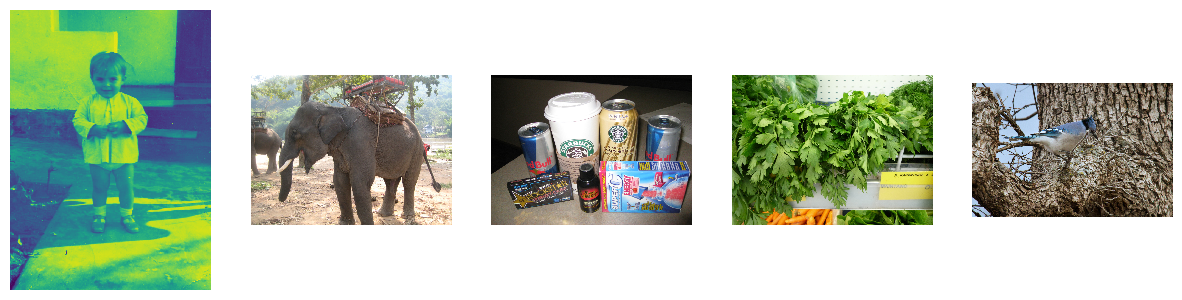

In [12]:
# Plot several samples from the dataset
def plot_sample_images(dataset):
    num_images = 5
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i, item in enumerate(dataset):
        item = dataset[i]
        image = item['image']
        caption = item.get('annotations_captions', [])
        print(caption)
        #image = image.permute(1, 2, 0).numpy()  # Convert to (H, W, C) for display
        
        axes[i].imshow(image, interpolation="nearest")
        #axes[i].set_title(caption, fontsize=10)
        axes[i].axis("off")
        if i == 4:
            break

    plt.show()

# Plot sample images
plot_sample_images(dataset_val)

**Training**

**part 1 - dVAE**

In [20]:
def dvae_loss(transformed_images, decoded_mu, decoded_log_b, token_probs, logits_gumbel, num_codebook_vectors=8192):
    """
    Compute dVAE loss:
    - Log-Laplace likelihood for reconstruction.
    - KL divergence loss using a uniform prior over the codebook.

    Args:
        transformed_images (torch.Tensor): Preprocessed images after ϕ transformation.
        decoded_mu (torch.Tensor): Predicted mean (µ) from decoder.
        decoded_log_b (torch.Tensor): Predicted log scale (ln b) from decoder.
        encoded (torch.Tensor): Encoded latent representation before quantization.
        num_codebook_vectors (int): Number of vectors in the VQ codebook (default: 8192).

    Returns:
        torch.Tensor: Total loss (reconstruction + KL divergence).
    """
    # Compute scale parameter (b) from log_b
    b = torch.exp(torch.clamp(decoded_log_b, min=-5, max=5))  # Convert ln b → b (scale parameter)

    # Apply logit function (inverse sigmoid) to transformed images
    logit_x = torch.log(transformed_images) - torch.log(1 - transformed_images)
    """
    # Logit-Laplace likelihood loss (reconstruction)
    loss_reconstruction = -(
        (1 / (2 * b * transformed_images * (1 - transformed_images))) *
        torch.exp(-torch.abs(logit_x - decoded_mu) / b)
    ).mean()
    """
    loss_reconstruction = torch.mean(
        torch.abs(logit_x - decoded_mu) / b + torch.log(2 * b * transformed_images * (1 - transformed_images))
    )
    
    # Compute log probability of tokens
    token_probs = token_probs.clamp(min=1e-5, max=1.0-1e-5)
    log_q = token_probs.log()  # Log-space distribution of quantized tokens
    #uniform_prior = torch.full_like(token_probs, 1 / num_codebook_vectors).to(torch.float32)  # log(1/8192)
    log_p = F.softmax(logits_gumbel, dim=-1)  # Learned categorical prior
    # KL divergence in log-space
    loss_kl = F.kl_div(log_q.to(torch.float32), log_p, reduction="batchmean")
    
    
    # Total loss (KL weight β = 6.6 as in the paper)
    loss = loss_reconstruction + 0.01 * loss_kl
    return loss_reconstruction, loss_reconstruction, loss_kl

In [4]:
from torch.optim.lr_scheduler import LambdaLR

def get_linear_scheduler(optimizer, num_training_steps, start_lr=1e-4, end_lr=1.25e-6):
    """
    Creates a linear learning rate scheduler.

    Args:
        optimizer: Optimizer whose LR will be scheduled.
        num_training_steps: Total number of training steps.
        start_lr: Initial learning rate (default: 1e-4).
        end_lr: Final learning rate (default: 1.25e-6).

    Returns:
        LambdaLR scheduler.
    """
    def lr_lambda(current_step):
        return max((1 - (current_step-1) / num_training_steps), 0.5)

    return LambdaLR(optimizer, lr_lambda)

In [4]:
# Define preprocessing function
def preprocess_image_batch(img_batch, target_res=256):
    """
    Preprocess a batch of images for training dVAE as OpenAI did in the paper.
    
    Args:
        img_batch (torch.Tensor): Batch of images (B, C, H, W), where values are in [0, 1].
        target_res (int): Target resolution (e.g., 256).
    
    Returns:
        torch.Tensor: Processed batch of images with shape (B, 3, target_res, target_res).
    """
    batch_size, channels, h, w = img_batch.shape

    # Step 1: Find minimum side and crop to a square
    s_min = min(h, w)
    img_batch = T.RandomCrop(size=(s_min, s_min))(img_batch)

    # Step 2: Random resizing in range [9/8 * target_res, 12/8 * target_res]
    t_min = min(s_min, round(9 / 8 * target_res))
    t_max = min(s_min, round(12 / 8 * target_res))
    t = torch.randint(low=t_min, high=t_max + 1, size=(1,)).item()  # Random target size

    img_batch = F.interpolate(img_batch, size=(t, t), mode="area")  # Resize using AREA method

    # Step 3: Final random crop to (target_res, target_res)
    img_batch = T.RandomCrop(size=(target_res, target_res))(img_batch)

    # Step 4: Random horizontal flip
    img_batch = T.RandomHorizontalFlip(p=0.5)(img_batch)

    return img_batch  # Output shape: (B, 3, target_res, target_res)

In [9]:
# Define a dataset for dVAE training (only images)
class dVAEDataset(Dataset):
    def __init__(self, image_caption_pairs):
        """
        dVAE dataset only needs images for training.

        Args:
            image_caption_pairs (list): List of (image, caption) pairs.
        """
        self.images = [pair[0].to(torch.float32) for pair in image_caption_pairs]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]  # Return only the image

In [16]:
# Training function for the discreate VAE model
def train_dVAE(dvae, dataloader, optimizer, scheduler, num_epochs=10, device="cuda"):
    dvae.train()
    scaler = GradScaler()
    for epoch in tqdm(range(num_epochs), desc="Training Progress (Epochs)"):
        total_loss = 0
        for images in dataloader:  # Ignore captions
            images = images.to(device) 
            optimizer.zero_grad()
            
            # Forward pass
            with autocast():
                encoded = dvae.encoder(images)
                indices, token_probs, logits_gumbel = dvae.vq(encoded)
                quantized = dvae.shared_image_embedding(indices)
                decoded_mu, decoded_log_b = dvae.decoder(quantized)
    
                # Compute loss
                loss, loss_reconstruction, loss_kl = dvae_loss(images, decoded_mu, decoded_log_b, token_probs, logits_gumbel, num_codebook_vectors=dvae.num_embeddings)

            # Backpropagation
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()    
            total_loss += loss.item()
        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}", flush=True)


In [11]:
def train_VAE(dvae, dataloader, optimizer, scheduler, num_epochs=10, device="cuda", procces=False):
    dvae.train()
    #scaler = GradScaler()
    for epoch in tqdm(range(num_epochs), desc="Training Progress (Epochs)"):
        total_loss = 0
        for images in dataloader:  # Ignore captions
            if procces:
                images = preprocess_image_batch(images, 256)
            images = images.to(device) 
            optimizer.zero_grad()
            loss = vae(images, return_loss = True)
            loss.backward()
            optimizer.step()
            # Forward pass
            """
            with autocast(device_type=device):
                loss = vae(images, return_loss = True)
            
            # Backpropagation
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            """
            total_loss += loss.item()
        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}", flush=True)


In [5]:
# Define model:
device = "cuda" if torch.cuda.is_available() else "cpu"
vae = DiscreteVAE(
    image_size = 256,
    num_layers = 4,
    num_tokens = 2048,
    codebook_dim = 128,
    hidden_dim = 64,
    num_resnet_blocks = 2,
    temperature = 0.2
).to(device)

In [12]:
# Define optimizer and HP
#dvae = dVAE().to(device)
optimizer_dvae = optim.AdamW(vae.parameters(), lr=1e-3, weight_decay=1e-4)
batch_size = 64
num_epochs = 20
dvae_train_dataset = dVAEDataset(train_data)
dataloader_vae = DataLoader(dvae_train_dataset, batch_size=batch_size, shuffle=True)

# Create scheduler
scheduler = get_linear_scheduler(optimizer_dvae, num_epochs)

In [24]:
# Train model
train_VAE(vae, dataloader_vae, optimizer_dvae, scheduler, num_epochs=10, procces=False)

Training Progress (Epochs):   0%|                                                                                          | 0/10 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacity of 7.93 GiB of which 514.88 MiB is free. Including non-PyTorch memory, this process has 7.43 GiB memory in use. Of the allocated memory 5.73 GiB is allocated by PyTorch, and 1.60 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

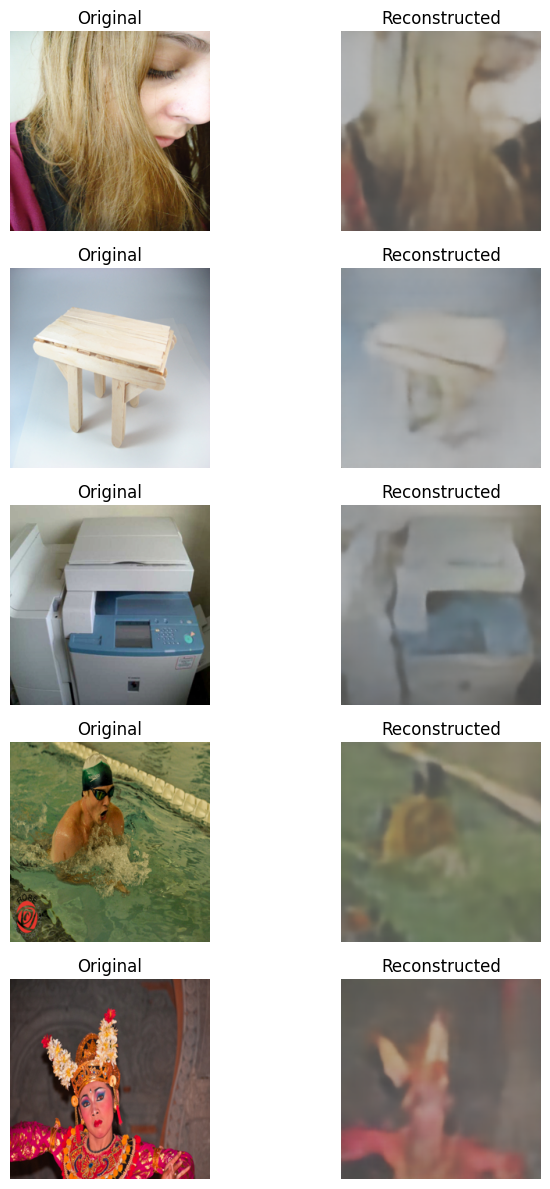

<Figure size 640x480 with 0 Axes>

In [13]:
# Define epsilon for ϕ transformation (same as in preprocessing)
EPSILON = 0.1

# Inverse of the ϕ transformation: (to bring images back to [0, 255])
def inverse_transform_pixels(x):
    return ((x - EPSILON) * (255.0 / (1 - 2 * EPSILON)))

# Function to visualize original vs. reconstructed images
def visualize_reconstruction(dvae, dataloader, device="cuda"):
    dvae.eval()  # Set model to evaluation mode

    # Get the first batch from the dataloader
    for images in dataloader:
        images = images[:5].to(device)  # Select first 5 images
        images = images.to(torch.float32)
        with torch.no_grad():
            # Forward pass through the dVAE
            decoded_mu = dvae(images, return_loss = False)
    
        # Convert tensors back to NumPy for visualization
        original_images = inverse_transform_pixels(images.to(torch.float16).cpu().float()).permute(0, 2, 3, 1).numpy().astype(np.uint8)
        reconstructed_images = inverse_transform_pixels(torch.sigmoid(decoded_mu.cpu().float())).permute(0, 2, 3, 1).numpy().astype(np.uint8)
    
        # Plot original vs reconstructed images
        fig, axes = plt.subplots(5, 2, figsize=(8, 12))
    
        for i in range(5):
            # Original Image
            axes[i, 0].imshow(original_images[i])
            axes[i, 0].set_title("Original")
            axes[i, 0].axis("off")
    
            # Reconstructed Image
            axes[i, 1].imshow(reconstructed_images[i])
            axes[i, 1].set_title("Reconstructed")
            axes[i, 1].axis("off")
    
        plt.tight_layout()
        plt.show()
        plt.savefig("dVAE_results.pdf")
        break

# Plot dVAE evaluation using reconstructed images
visualize_reconstruction(vae, dataloader_vae)

In [22]:
# Save model:
torch.save(vae, "dvae_model.pth")

In [23]:
# Save model (weights only)
torch.save(vae.state_dict(), "dvae_weights.pth")

In [6]:
# Load existing model
vae.load_state_dict(torch.load("dvae_weights.pth"))

/tmp/ipykernel_208354/1066352927.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("dvae_weights.pth"))


<All keys matched successfully>

**Part 2 - transformer**

In [14]:
from transformers import GPT2Tokenizer

class TransformerDataset(Dataset):
    def __init__(self, train_data, vqvae, text_seq_len=128, vocab_size=10000, device="cuda"):
        """
        Args:
            train_data (list of tuples): List of (image, caption) pairs.
            vqvae (VQVAE): Pre-trained VQ-VAE model to encode images.
            text_seq_len (int): Maximum tokenized text length.
            device (str): Device to run VQ-VAE encoding on (default: "cuda").
        """
        self.text_seq_len = text_seq_len
        self.device = device
        self.vocab_size = vocab_size
        
        # Load GPT-2 tokenizer
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        self.tokenizer.pad_token = self.tokenizer.eos_token  # Ensure padding is valid
        
        # Precompute image tokens
        self.data = self.precompute_image_tokens(train_data, vqvae)
        
    def precompute_image_tokens(self, train_data, vqvae):
        """Encodes all images once using the VQ-VAE and returns a list of (text_tokens, image_tokens)."""
        precomputed_data = []
        
        vqvae.to(self.device)
        vqvae.eval()  # Ensure VQ-VAE is in inference mode
        
        for image, caption in train_data:
            image = image.to(self.device).unsqueeze(0)  # Add batch dimension
            with torch.no_grad():
                image_tokens = vqvae.get_codebook_indices(image).squeeze(0)  # Encode image once
            
            # Tokenize text caption
            text_tokens = self.tokenizer.encode(caption, return_tensors="pt", max_length=self.text_seq_len, truncation=True, padding="max_length")
            text_tokens = text_tokens.squeeze(0)  # Remove batch dimension
            text_tokens = text_tokens % self.vocab_size
            
            precomputed_data.append((text_tokens, image_tokens.cpu()))  # Move to CPU to save GPU memory
        
        return precomputed_data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]  # Directly return precomputed (text_tokens, image_tokens)


In [15]:
def train_transformer(transformer, dataloader, optimizer, scheduler, num_epochs=10, device="cuda"):
    """
    Trains the DALL·E Transformer.

    Args:
        transformer (DALLE): The Transformer model for text-to-image generation.
        dataloader (DataLoader): DataLoader containing (text_tokens, image_tokens).
        optimizer (torch.optim.Optimizer): Optimizer for training.
        scheduler (torch.optim.lr_scheduler): Learning rate scheduler.
        num_epochs (int): Number of training epochs.
        device (str): Device to run the training on (default: "cuda").
    """
    transformer.train()
    #scaler = GradScaler()
    for epoch in tqdm(range(num_epochs), desc="Training Progress (Epochs)"):
        total_loss = 0
        
        for text_tokens, image_tokens in dataloader:
            text_tokens, image_tokens = text_tokens.to(device), image_tokens.to(device)

            optimizer.zero_grad()

            """
            with autocast(device_type=device):
                loss = transformer(text_tokens, image_tokens, return_loss=True)
            
            # Backpropagation
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            """
            
            # Forward pass
            loss = transformer(text_tokens, image_tokens, return_loss=True)

            # Backpropagation
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}", flush=True)


In [18]:
# Define model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dalle = DALLE(
    dim = 256,
    vae = vae,                  # automatically infer (1) image sequence length and (2) number of image tokens
    num_text_tokens = 10000,    # vocab size for text
    text_seq_len = 128,         # text sequence length
    depth = 6,                 # should aim to be 64
    heads = 4,                 # attention heads
    dim_head = 64,              # attention head dimension
    attn_dropout = 0.1,         # attention dropout
    ff_dropout = 0.1            # feedforward dropout
).to(device)

In [19]:
# Define HP and optimizer
optimizer_transformer = optim.AdamW(dalle.parameters(), lr=4.5e-4, weight_decay=4.5e-2, betas=(0.9, 0.96))
num_epochs = 20
batch_size = 16
transformer_train_dataset = TransformerDataset(train_data, vae)
dataloader_transformer = DataLoader(transformer_train_dataset, batch_size=batch_size, shuffle=True)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    
# Define total training steps
num_training_steps = len(dataloader_transformer) * num_epochs
# Create scheduler
scheduler = get_linear_scheduler(optimizer_transformer, num_training_steps, start_lr=4.5e-4, end_lr=4.5e-6)

In [87]:
# Train Transformer
train_transformer(dalle, dataloader_transformer, optimizer_transformer, scheduler, num_epochs=num_epochs)

Training Progress (Epochs):   0%|                                                                                          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 2.1692


Training Progress (Epochs):   5%|███▉                                                                          | 1/20 [20:15<6:24:54, 1215.49s/it]

Epoch [2/20], Loss: 1.6672


Training Progress (Epochs):  10%|███████▊                                                                      | 2/20 [40:31<6:04:41, 1215.64s/it]

Epoch [3/20], Loss: 1.1307


Training Progress (Epochs):  15%|███████████▍                                                                | 3/20 [1:00:46<5:44:25, 1215.59s/it]

Epoch [4/20], Loss: 0.8479


Training Progress (Epochs):  20%|███████████████▏                                                            | 4/20 [1:21:02<5:24:10, 1215.68s/it]

Epoch [5/20], Loss: 0.7013


Training Progress (Epochs):  25%|███████████████████                                                         | 5/20 [1:41:17<5:03:52, 1215.53s/it]

Epoch [6/20], Loss: 0.6139


Training Progress (Epochs):  30%|██████████████████████▊                                                     | 6/20 [2:01:33<4:43:36, 1215.48s/it]

Epoch [7/20], Loss: 0.5548


Training Progress (Epochs):  35%|██████████████████████████▌                                                 | 7/20 [2:21:48<4:23:21, 1215.49s/it]

Epoch [8/20], Loss: 0.5124


Training Progress (Epochs):  40%|██████████████████████████████▍                                             | 8/20 [2:42:03<4:03:04, 1215.38s/it]

Epoch [9/20], Loss: 0.4786


Training Progress (Epochs):  45%|██████████████████████████████████▏                                         | 9/20 [3:02:18<3:42:47, 1215.19s/it]

Epoch [10/20], Loss: 0.4532


Training Progress (Epochs):  50%|█████████████████████████████████████▌                                     | 10/20 [3:22:33<3:22:31, 1215.14s/it]

Epoch [11/20], Loss: 0.4317


Training Progress (Epochs):  55%|█████████████████████████████████████████▎                                 | 11/20 [3:44:59<3:04:04, 1227.22s/it]


KeyboardInterrupt: 

In [76]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define epsilon for inverse transformation (same as used in preprocessing)
EPSILON = 0.1

# Inverse of the ϕ transformation: (to bring images back to [0, 255])
def inverse_transform_pixels(x):
    return ((x - EPSILON) * (255.0 / (1 - 2 * EPSILON)))

# Function to evaluate the Transformer model
def evaluate_transformer(transformer, dvae, dataloader, tokenizer, image_caption_pairs, device="cuda", num_samples=5):
    """
    Evaluates the DALL·E Transformer by generating images from text prompts and comparing them to:
    1. The original images
    2. dVAE-reconstructed images

    Args:
        transformer (DALLE): Trained Transformer model.
        dvae (VQVAE): Pre-trained dVAE model for encoding and decoding.
        dataloader (DataLoader): DataLoader containing (text_tokens, image_tokens).
        tokenizer (GPT2Tokenizer): Tokenizer used for encoding text.
        image_caption_pairs (list): List of (image, caption) pairs for ground truth comparison.
        device (str): Device to run the evaluation on.
        num_samples (int): Number of images to generate and display.
    """
    transformer.eval()
    dvae.eval()

    # Get a batch of text captions
    for text_tokens, image_tokens in dataloader:
        text_tokens = text_tokens[:num_samples].to(device)  # Select first `num_samples`
        image_tokens = image_tokens[:num_samples].to(device)
        
        with torch.no_grad():
            # Generate image tokens from text using the Transformer
            generated_images = transformer.generate_images(text_tokens)

        # Convert generated images to NumPy
        generated_images = inverse_transform_pixels(torch.sigmoid(generated_images.cpu().float()))
        generated_images = generated_images.permute(0, 2, 3, 1).numpy().astype(np.uint8)

        # Get text captions for visualization
        captions = [tokenizer.decode(text.tolist(), skip_special_tokens=True).split(" t")[0] for text in text_tokens]

        with torch.no_grad():
            dvae_recon = dvae.decode(image_tokens)
        dvae_reconstructed_images = []
        for image in dvae_recon:
              # Encode & decode with dVAE
            dvae_reconstructed_images.append(inverse_transform_pixels(torch.sigmoid(image.cpu().squeeze(0))).permute(1, 2, 0).numpy().astype(np.uint8))
        
        # Plot original vs dVAE reconstructed vs generated images
        fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 3, 9))

        for i in range(num_samples):
            # dVAE Reconstructed Image
            axes[0, i].imshow(dvae_reconstructed_images[i])
            axes[0, i].set_title(f"dVAE Reconstruction\n{" ".join(captions[i].split(" ")[:5])}\n{" ".join(captions[i].split(" ")[5:])}")
            axes[0, i].axis("off")
        
            # Generated Image
            axes[1, i].imshow(generated_images[i])
            axes[1, i].set_title(f"Generated by Model")  # Reduce font size if needed
            axes[1, i].axis("off")

        plt.tight_layout()
        plt.show()
        plt.savefig("transformer_results.pdf")
        break  # Only process one batch

In [77]:
def evaluate_transformer_new_captions(transformer, dvae, tokenizer, new_captions, device="cuda"):
    """
    Evaluates the DALL·E Transformer by generating images from unseen text prompts.

    Args:
        transformer (DALLE): Trained Transformer model.
        dvae (VQVAE): Pre-trained dVAE model for encoding and decoding.
        tokenizer (GPT2Tokenizer): Tokenizer used for encoding text.
        image_caption_pairs (list): List of captions for wanted images.
        device (str): Device to run the evaluation on.
    """
    transformer.eval()
    dvae.eval()

    tokenizer.pad_token = tokenizer.eos_token
    new_text_tokens = tokenizer(new_captions, return_tensors="pt", padding="max_length", truncation=True, max_length=128).input_ids.to(device)

    with torch.no_grad():
        new_generated_image = transformer.generate_images(new_text_tokens)

    new_generated_images = inverse_transform_pixels(torch.sigmoid(new_generated_images.cpu().float()))
    new_generated_images = new_generated_images.permute(0, 2, 3, 1).numpy().astype(np.uint8)

    # Plot original vs dVAE reconstructed vs generated images
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 3, 12))

    for i in range(new_captions):
        # Plot Generated Image 
        axes[0, i].imshow(new_generated_images[i])
        axes[0, i].set_title(f"Caption {i}\n{" ".join(new_captions[i].split(" ")[:5])}\n{" ".join(new_captions[i].split(" ")[5:])}")
        axes[0, i].axis("off")
    plt.tight_layout()
    plt.show()
    plt.savefig("transformer_results_for_new_captions.pdf")

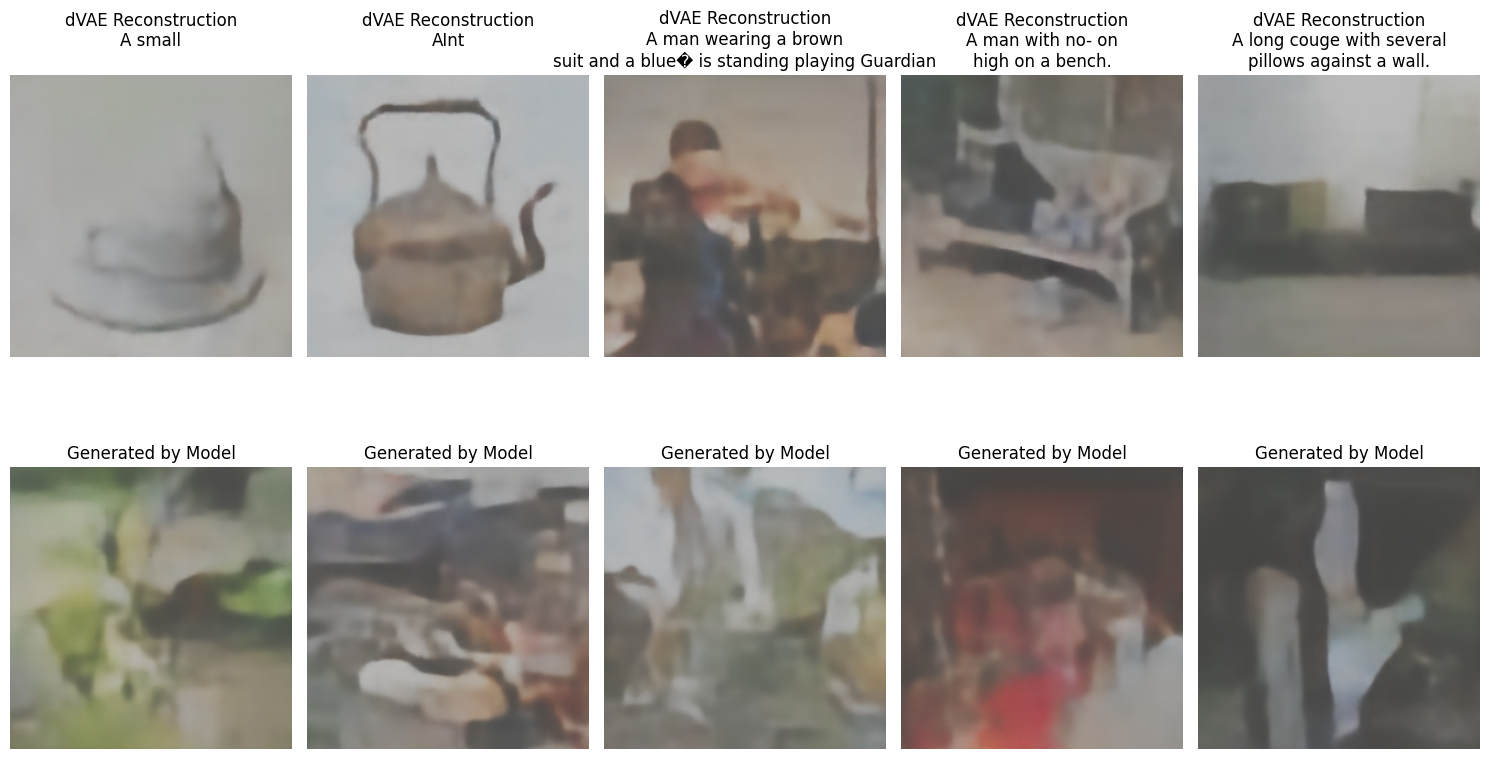

<Figure size 640x480 with 0 Axes>

In [82]:
# Evaluate DALL-E model
evaluate_transformer(
    transformer=dalle, 
    dvae=vae, 
    dataloader=dataloader_transformer, 
    tokenizer=tokenizer, 
    image_caption_pairs=train_data,  # List of (image, caption) pairs
    device="cuda", 
    num_samples=5
)

# Generate images from 5 manually written captions
new_captions = [
    "A cat sitting on a windowsill",
    "A person riding a bicycle in the park",
    "A bowl of fresh fruit on a wooden table",
    "A group of people walking on the beach",
    "A red car driving on a highway"
]



In [ ]:
# Save model:
torch.save(dalle, "dall-e_model.pth")

In [91]:
# Save model (weights only)
torch.save(dalle.state_dict(), "dall-e_model_weights.pth")

In [21]:
# Load existing model
dalle.load_state_dict(torch.load("dall-e_model_weights.pth"))

/tmp/ipykernel_208354/1740858511.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dalle.load_state_dict(torch.load("dall-e_model_weights.pth"))


<All keys matched successfully>